This notebook provides the code presented in the blog post [Collaborative Filtering Using Embeddings](https://www.onceupondata.com/2019/02/01/nn-collaborative-filtering/).  We will use the [goodbooks-10k](https://github.com/zygmuntz/goodbooks-10k) dataset, which contains *" around six million ratings for ten thousand books"*.  The post will explain  the high-level concepts then it will show preliminary **Keras** models to demonstrate two methods in which we can use embeddings to represent our data. We will refer to the two methods as:

-  Matrix factorization method
-  Tabular data method 

**Note that the examples are for demo purposes and they are not intended to provide the best model. Also I am not aware of a benchmark for this dataset, so the comparison with other models is out of the scope*

## Matrix Factorization, Latent Factors and Embeddings

In a platform like goodreads, we see book recommendations based on the history of the user, similarities with other users or other signals collected about the user behavior. In practice, different signals and algorithms are usually merged to get better results. But let's focus on one approach; **item-based collaborative filtering**. Using this approach, we learn about the similarities between the books using the ratings we already have. Starting with tabular data, the first step is to convert our table to a matrix with one row per user as shown in the following figure. 

![alt text](https://github.com/OmaymaS/onceupondata/blob/master/static/post/2019-02-01_goodreads-book-recommendation/table_to_matrix.png?raw=true)

**But what is the problem with that?**

Usually we'll have thousands of users and items, so this matrix will be very sparse with dimensions **(mXn)** .

**What is the common solution?**

To reduce the complexity of the problem, it is common to deal with lower-dimension matrices using matrix factorization. The idea is to represet each user/item by a compact vector represting the latent factors. 

**And How can embeddings help?**

Instead of the traditional ways, we can use embedding layers and learn about the latent factors while training our neural network using the given ratings. As a result we will have:

- Users embedding **(mXk)**
- Items embedding **(nXk)** 

Ideally, with a good model, users/items close to each other in the space should have similar characteristics.

 ![](https://github.com/OmaymaS/onceupondata/blob/master/static/post/2019-02-01_goodreads-book-recommendation/embedding_matrix.png?raw=true)

Then we can use these matrices in two ways:

1-  **Matrix factorization method**  where we take these matrices, calculate the element-wise product of **(mXk),(kXm)** then add other fully connected layers.


 ![](https://github.com/OmaymaS/onceupondata/blob/master/static/post/2019-02-01_goodreads-book-recommendation/matrix_to_embedding2.png?raw=true)

2 - **Tabular data method** where we use the embedding matrices as lookup tables to get the vectors corresponding to each user/item. These vectors will be consideres as features and we can add other fully connected layers, or even try something else other than neural networks.

 ![](https://github.com/OmaymaS/onceupondata/blob/master/static/post/2019-02-01_goodreads-book-recommendation/table_to_tabular.png?raw=true)

## Dataset

Now as we got the idea behind using embeddings, let's start with loading the goodreads `ratings` dataset. Notice that it is similar to the illustrated example above, where we have **user_id, book_id, rating**. 

In [0]:
## import libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
## read data
ratings = pd.read_csv("https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv")
books = pd.read_csv("https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv")

ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


#### Unique users/books

In [0]:
## unisue users, books
n_users, n_books = len(ratings.user_id.unique()), len(ratings.book_id.unique())


f'The dataset includes {len(ratings)} ratings by {n_users} unique users on {n_books} unique books.'

'The dataset includes 5976479 ratings by 53424 unique users on 10000 unique books.'

#### Rating distribution

If we look at the distribution of ratings, We can notice that:

- the values are discrete (1 to 5), but we will deal with them as continuous as we are ok with predicting intermediate values.

- the data is unbalanced, and most of the ratings are from 3 to 5. (*Ideally we should consier the impact of such imbalance on the model*)

(array([ 124195.,       0.,  359257.,       0.,       0., 1370916.,
              0., 2139018.,       0., 1983093.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

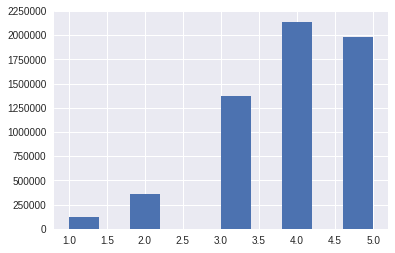

In [4]:
## plot a histogram of ratings
plt.hist(ratings['rating'])

#### Train/Test Split

We can look further into the dataset and select books with number of reviews above a certain threshold, or exclude certain records. But for simplicity, we will use the data as is and keep 10% for testing.

In [0]:
from sklearn.model_selection import train_test_split

## split the data to train and test dataframes
train, test = train_test_split(ratings, test_size = 0.1)

f"The training and testing data include {len(train), len(test)} records."

'The training and testing data include (5378831, 597648) records.'

## Keras Models

As we have our data ready, we can create Keras models to implement the concepts discussed above. We will use the functional API as we need to bulid multi-input models.

In [0]:
## import keras models, layers and optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input
from keras.optimizers import Adam

## for model block diagram visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

### 1- Matrix factorization method

The core of this methods is having:

- **users and books embedding layers** with the same number of factors.
- **user and books bias layers** which can be considered as representation of the unique inherent characteristic of each user/book.

We will take the element-wise product of the two embeddings and add the bias terms. The rest is all about experimenting with layers and tuning hyper parameters.


#### Create model

In [0]:
## define embedding size (similar for both users and books)
dim_embedddings = 32
bias = 1

# books
book_input = Input(shape=[1],name='Book')
book_embedding = Embedding(n_books+1, dim_embedddings, name="Book-Embedding")(book_input)
book_bias = Embedding(n_books + 1, bias, name="Book-Bias")(book_input)

# users
user_input = Input(shape=[1],name='User')
user_embedding = Embedding(n_users+1, dim_embedddings, name="User-Embedding")(user_input)
user_bias = Embedding(n_users + 1, bias, name="User-Bias")(user_input)


matrix_product = multiply([book_embedding, user_embedding])
matrix_product = Dropout(0.2)(matrix_product)

input_terms = concatenate([matrix_product, user_bias, book_bias])
input_terms = Flatten()(input_terms)

## add dense layers
dense_0 = Dense(128, activation="relu", name = "Dense0")(input_terms)
dense_1 = Dropout(0.2)(dense_0)
dense_1 = Dense(64, activation="relu", name = "Dense1")(dense_0)
dense_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(32, activation="relu", name = "Dense2")(dense_1)
dense_2 = Dropout(0.2)(dense_2)
result = Dense(1, activation='relu', name='Activation')(dense_2)

## define model with 2 inputs and 1 output
model_mf = Model(inputs=[book_input, user_input], outputs = result)

## show model summary
model_mf.summary()
   

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 32)        320032      Book[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 32)        1709600     User[0][0]                       
__________________________________________________________________________________________________
multiply_5

#### Show model diagram

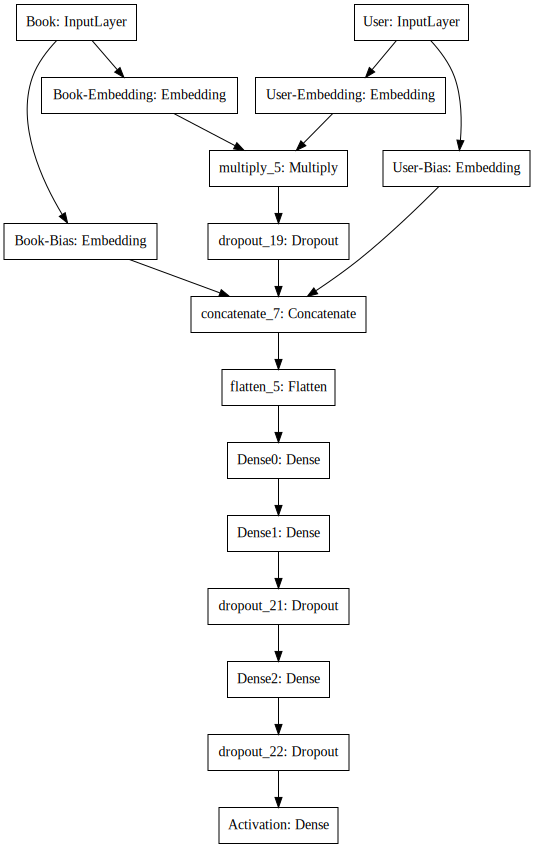

In [0]:
SVG(model_to_dot(model_mf).create(prog='dot', format='svg'))

#### Train model

We will initially train the model for 4 epochs and monitor  the loss on the training and validation data.

In [0]:
## specify learning rate (or use the default)
opt_adam = Adam(lr = 0.002)

## compile model
model_mf.compile(optimizer = opt_adam, loss = ['mse'], metrics = ['mean_absolute_error'])

## fit model
history_mf = model_mf.fit([train['user_id'], train['book_id']],
                          train['rating'],
                          batch_size = 256,
                          validation_split = 0.005,
                          epochs = 16,
                          verbose = 1)

Train on 5351936 samples, validate on 26895 samples
Epoch 1/16
5351936/5351936 [==============================] - 206s 39us/step - loss: 0.9524 - mean_absolute_error: 0.7776 - val_loss: 0.8873 - val_mean_absolute_error: 0.7417
Epoch 2/16
5351936/5351936 [==============================] - 205s 38us/step - loss: 0.8866 - mean_absolute_error: 0.7499 - val_loss: 0.8807 - val_mean_absolute_error: 0.7451
Epoch 3/16
5351936/5351936 [==============================] - 205s 38us/step - loss: 0.8768 - mean_absolute_error: 0.7446 - val_loss: 0.8793 - val_mean_absolute_error: 0.7427
Epoch 4/16
5351936/5351936 [==============================] - 203s 38us/step - loss: 0.8732 - mean_absolute_error: 0.7404 - val_loss: 0.8784 - val_mean_absolute_error: 0.7434
Epoch 5/16
5351936/5351936 [==============================] - 203s 38us/step - loss: 0.8627 - mean_absolute_error: 0.7349 - val_loss: 0.8784 - val_mean_absolute_error: 0.7419
Epoch 6/16
5351936/5351936 [==============================] - 203s 38us/s

#### Interpretation of embedding/bias values

Ideally, if we have trained the model enough to learn about the latent factors of the users/books, the values of the bias or embedding matrices should have a meaning about the underlying characteristcs of what they represent. Although this model is preliminary, we will see how we could interprent these values with a good model.

First, we will create a dictionary with the book id and title.

In [0]:
## create a dictionary out of bookid, book original title
books_dict = books.set_index('book_id')['original_title'].to_dict()

Then we will extract the book embedding weights, and we can see it has the expected dimensions.

In [0]:
book_embedding_weights = model_mf.layers[2].get_weights()[0]
book_embedding_weights.shape

(10001, 32)

To compress these these vectors into less dimensions, we can use **Principal Component Analysis(PCA)**, to reduce the `dim_embedddings` to three components.

In [0]:
## import PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 3) ## use 3 components
book_embedding_weights_t = np.transpose(book_embedding_weights) ## pass the transpose of the embedding matrix
book_pca = pca.fit(book_embedding_weights_t) ## fit

## display the resulting matrix dimensions
book_pca.components_.shape

(3, 10001)

We can look at the percentage of variance explained by each of the selected components.

In [0]:
## display the variance explained by the 3 components
book_pca.explained_variance_ratio_

array([0.05997574, 0.04405401, 0.04194602], dtype=float32)

If the variance explained is very low, we might not be able to see a good interpretation. However, for demo purposes, we will just extract the first component/factor that explains the highest percentage of the variance. The array we get can be mapped to the books list.

In [0]:
from operator import itemgetter

## extract first PCA
pca0 = book_pca.components_[0]

## get the value (pca0, book title)
book_comp0 = [(f, books_dict[i]) for f,i in zip(pca0, list(books_dict.keys()))]

If we look at the two extremes on this axis, we will get the following results. **Ideally with a good model, we should find the top ten books sharing a certain feature like (genre, movies, etc.), while the lowest ten should be on the opposite side.**


In [0]:
## books corresponding to the highest values of pca0
sorted(book_comp0, key = itemgetter(0), reverse = True)[:10]

[(0.039083663, 'Der Schweizerische Robinson'),
 (0.03763531, 'Abhorsen'),
 (0.037420202, 'Traveling Mercies: Some Thoughts on Faith'),
 (0.036263224, 'Lola and the Boy Next Door'),
 (0.035904933, 'The Reluctant Fundamentalist'),
 (0.034426596, 'The Golden Fool'),
 (0.033787396, 'Anna and the French Kiss'),
 (0.032591347, 'Big Nate on a Roll'),
 (0.03244199, 'A Court of Thorns and Roses'),
 (0.03244152, 'Calico Joe')]

In [0]:
## books corresponding to the lowest values of pca0
sorted(book_comp0, key = itemgetter(0))[:10]

[(-0.03538448, nan),
 (-0.03486702, 'The Bride'),
 (-0.03396777, 'Trump: The Art of the Deal'),
 (-0.03219103, 'The Unexpected Mrs. Pollifax'),
 (-0.031592738, nan),
 (-0.031210287, nan),
 (-0.03081872, 'The Road to Little Dribbling'),
 (-0.030535161, 'Batman: The Black Mirror'),
 (-0.030096786,
  'The Surgeon of Crowthorne: a tale of murder, madness & the love of words'),
 (-0.029848108,
  'Amusing Ourselves to Death: Public Discourse in the Age of Show Business')]

### 2- Tabular data method

In this method, we will just have users and books embedding layers that can have different dimensions. We will concatenate them together as if we have a table with `dim_embedding_user+dim_embedding_book` features. Then we can add dense layers, or even use these weights as features with other algorithms. 

#### Define model

In [0]:
## define the number of latent factors (can be different for the users and books)
dim_embedding_user = 32
dim_embedding_book = 32

## book embedding
book_input= Input(shape=[1], name='Book')
book_embedding = Embedding(n_books + 1, dim_embedding_book, name='Book-Embedding')(book_input)
book_vec = Flatten(name='Book-Flatten')(book_embedding)
book_vec = Dropout(0.2)(book_vec)

## user embedding
user_input = Input(shape=[1], name='User')
user_embedding = Embedding(n_users + 1, dim_embedding_user, name ='User-Embedding')(user_input)
user_vec = Flatten(name ='User-Flatten')(user_embedding)
user_vec = Dropout(0.2)(user_vec)

## concatenate flattened values 
concat = concatenate([book_vec, user_vec])
concat_dropout = Dropout(0.2)(concat)

## add dense layer (can try more)
dense_1 = Dense(20, name ='Fully-Connected1', activation='relu')(concat)

## define output (can try sigmoid instead of relu)
result = Dense(1, activation ='relu',name ='Activation')(dense_1)

## define model with 2 inputs and 1 output
model_tabular = Model([user_input, book_input], result)

## show model summary
model_tabular.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 32)        320032      Book[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 32)        1709600     User[0][0]                       
__________________________________________________________________________________________________
Book-Flatt

#### Show model diagram

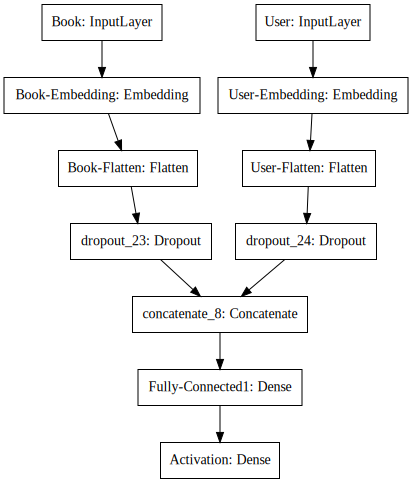

In [0]:
SVG(model_to_dot(model_tabular).create(prog='dot', format='svg'))

#### Train model

In [0]:
## specify learning rate (or use the default by specifying optimizer = 'adam')
opt_adam = Adam(lr = 0.002)

## compile model
model_tabular.compile(optimizer= opt_adam, loss= ['mse'], metrics=['mean_absolute_error'])

## fit model
history_tabular = model_tabular.fit([train['user_id'], train['book_id']],
                                    train['rating'],
                                    batch_size = 256,
                                    validation_split = 0.005,
                                    epochs = 16,
                                    verbose = 1)

Train on 5351936 samples, validate on 26895 samples
Epoch 1/16
5351936/5351936 [==============================] - 165s 31us/step - loss: 0.8301 - mean_absolute_error: 0.7055 - val_loss: 0.7267 - val_mean_absolute_error: 0.6621
Epoch 2/16
5351936/5351936 [==============================] - 165s 31us/step - loss: 0.7243 - mean_absolute_error: 0.6641 - val_loss: 0.7067 - val_mean_absolute_error: 0.6535
Epoch 3/16
5351936/5351936 [==============================] - 166s 31us/step - loss: 0.6999 - mean_absolute_error: 0.6505 - val_loss: 0.6921 - val_mean_absolute_error: 0.6520
Epoch 4/16
5351936/5351936 [==============================] - 166s 31us/step - loss: 0.6815 - mean_absolute_error: 0.6402 - val_loss: 0.6804 - val_mean_absolute_error: 0.6347
Epoch 5/16
5351936/5351936 [==============================] - 166s 31us/step - loss: 0.6691 - mean_absolute_error: 0.6330 - val_loss: 0.6777 - val_mean_absolute_error: 0.6455
Epoch 6/16
5351936/5351936 [==============================] - 167s 31us/s

This model performs better that the first one after 4 epochs. Part of the experimentation is to train both for more epochs,  tune the hyperparamers or modify the architecture.

#### Predict ratings of test data

If we want to check the model, we can use the test data which gives `mse` close to the validation loss.

In [0]:
## import libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error

## define a function to return arrays in the required form 
def get_array(series):
    return np.array([[element] for element in series])

## predict on test data  
predictions = model_tabular.predict([get_array(test['user_id']), get_array(test['book_id'])])

f'mean squared error on test data is {mean_squared_error(test["rating"], predictions)}'

'mean squared error on test data is 0.6727620986954058'

### 3- Other methods

Although we saw preliminary models we could get the idea behind each of the methods and we have a starting point to experiment more. There's also another approach which almost combines both methods. It was published in a paper entitled [Neural Collaborative Filtering](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf). It is not included in this notebook but it was worth mentioning as we discuss similar methods.

 ![](https://github.com/OmaymaS/onceupondata/blob/master/static/post/2019-02-01_goodreads-book-recommendation/nn_paper.png?raw=true)
*Source: [Neural Collaborative Filtering](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf), Xiangnan He, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu, and Tat-Seng Chua.*

## References and Readings

- Practical Deep Learning for Coders [Lesson 4: NLP, Tabular data, Collaborative filtering, Embeddings](https://course.fast.ai/videos/?lesson=4), Jeremy Howard, fast.ai
-  [Understanding Latent Style](https://multithreaded.stitchfix.com/blog/2018/06/28/latent-style/), Erin Boyle and Jana Beck, StichFix
- [Neural Collaborative Filtering](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf), Xiangnan He, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu, and Tat-Seng Chua.
